# Introduction

Excessive drug use is a public health problem that affects millions of people worldwide. According to the 2021 World Drug Report by the UN, around 275 million people used drugs at least once in the previous year, and about 36 million suffered from drug use disorders. Effective prevention and treatment programs can significantly reduce the negative impacts of drug abuse. Data shows that every dollar invested in dependency treatment can result in a savings of up to 7 dollars in crime-related and judicial costs. Furthermore, treatment and rehabilitation can improve individuals' quality of life and facilitate their reintegration into society.

# Objective


My goal with this notebook is to interpret the use of drugs by the global population and to explore any relationship between substance use and the individual's psyche. Additionally, a study and classification model will be conducted to determine whether a given individual is prone to using certain substances. The idea is that this mini-project will serve as a foundation for anyone wishing to conduct future analyses for the prevention and treatment of people in this situation, a problem that persists in my home country, Brazil.

You can also see the project on my github: https://github.com/Andre647/Drug_Usage

I consider this notebook just the first version of this project. As I delve into different data science techniques, I intend to come back here and improve what has already been done. Therefore, any feedback is welcome :)

# Data Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, f1_score)
from sklearn.model_selection import GridSearchCV, train_test_split

In [2]:
df = pd.read_csv("/kaggle/input/drug-consumption-classification/drug_consumption.csv")
df.head()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


# EDA

## Data Understanding

In [3]:
# Dataframe size
df.shape

(1885, 32)

In [4]:
df.dtypes

ID             int64
Age          float64
Gender       float64
Education    float64
Country      float64
Ethnicity    float64
Nscore       float64
Escore       float64
Oscore       float64
Ascore       float64
Cscore       float64
Impulsive    float64
SS           float64
Alcohol       object
Amphet        object
Amyl          object
Benzos        object
Caff          object
Cannabis      object
Choc          object
Coke          object
Crack         object
Ecstasy       object
Heroin        object
Ketamine      object
Legalh        object
LSD           object
Meth          object
Mushrooms     object
Nicotine      object
Semer         object
VSA           object
dtype: object

In [5]:
df.select_dtypes('object').describe()

,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
count,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885
unique,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,5,7
top,CL5,CL0,CL0,CL0,CL6,CL6,CL6,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0,CL0
freq,759,976,1305,1000,1385,463,807,1038,1627,1021,1605,1490,1094,1069,1429,982,610,1877,1455


In [6]:
df.isna().any()

ID           False
Age          False
Gender       False
Education    False
Country      False
Ethnicity    False
Nscore       False
Escore       False
Oscore       False
Ascore       False
Cscore       False
Impulsive    False
SS           False
Alcohol      False
Amphet       False
Amyl         False
Benzos       False
Caff         False
Cannabis     False
Choc         False
Coke         False
Crack        False
Ecstasy      False
Heroin       False
Ketamine     False
Legalh       False
LSD          False
Meth         False
Mushrooms    False
Nicotine     False
Semer        False
VSA          False
dtype: bool

## Data Cleaning

* Since my goal is for this study to be applicable in Brazil one day, I will remove the country  column and since we have multiple columns of drugs in the dataset, those not listed in the national survey on drug use by the Brazilian population (https://www.arca.fiocruz.br/handle/icict/34614) will be removed. Additionally, drugs with low potential for harm, such as caffeine or chocolate, will also be excluded.
* Respecting LGPD (Brazilian data protection law), gender and ethnicity columns will also be removed to ensure model neutrality.

In [7]:
df = df.drop(columns=[
    'ID', 'Gender', 'Ethnicity', 'Country', 'Amphet', 'Amyl', 
    'Caff', 'Choc', 'Ketamine', 'Legalh', 'Semer'
])

## Data transformation

All categorical values in the CSV were converted to numerical values; to conduct the study, I'm transforming them back to their original values.(Special thanks for @mexwell, owner of the dataset, for providing the code)

In [8]:
age_col = {
    -0.95197: '18-24',
    -0.07854: '25-34',
    0.49788: '35-44',
    1.09449: '45-54',
    1.82213: '55-64',
    2.59171: '65+'
}


df['Age'] = df['Age'].replace(age_col)

In [9]:
education_col = {
    -2.43591: 'LSB16',       # Left School Before 16
    -1.73790: 'LS16',        # Left School at 16
    -1.43719: 'LS17',        # Left School at 17
    -1.22751: 'LS18',        # Left School at 18
    -0.61113: 'Some College',
    -0.05921: 'Certificate',
    0.45468: 'University',
    1.16365: 'Masters',
    1.98437: 'Doctorate'
}


df['Education'] = df['Education'].replace(education_col)

To facilitate the creation of the model and simplify the problem outputs, I will consider 'Never Used' (CL0), 'Used over a Decade Ago' (CL1), and 'Used in Last Decade' (CL2) as not prone to use **(0)**, and 'Used in Last Year' (CL3), 'Used in Last Month' (CL4), 'Used in Last Week' (CL5), and 'Used in Last Day' (CL6) as prone to use **(1)**.

In [10]:
usage_col = {
    'CL0': 0,
    'CL1': 0,
    'CL2': 0,
    'CL3': 1,
    'CL4': 1,
    'CL5': 1,
    'CL6': 1
}

# Replace categorical drug usage columns with numerical values
df_age_education = df[['Age', 'Education']]
df_numbers = df.select_dtypes('number')
df_drugs = (df.select_dtypes('object')
                .drop(columns=['Age', 'Education'])
                .replace(usage_col))

/tmp/ipykernel_18/402558104.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(usage_col))


In [11]:
# Rejoin original columns with numerical and drug usage data
df = df_age_education.join(df_numbers, how='outer')
df = df.join(df_drugs, how='outer')

## Data Vis

### General

In [12]:
import warnings

# Suppress FutureWarnings specifically from the seaborn module
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

sns.set_palette("Set2", 2)

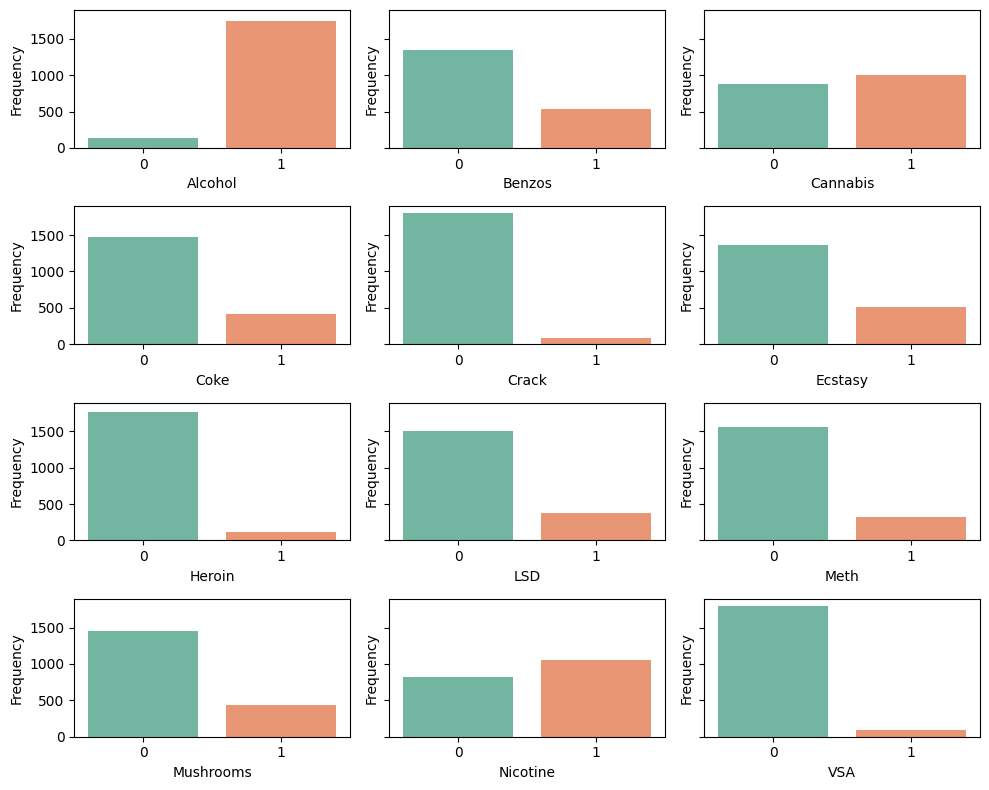

In [13]:
# Distribution of users/non-users per drug
fig, axes = plt.subplots(4, 3, figsize=(10, 8), sharey=True)

for ax, coluna in zip(axes.flatten(), df_drugs.columns):
    sns.countplot(x=coluna, data=df, ax=ax)
    ax.set_ylabel('Frequency')
    

plt.tight_layout()
plt.show()

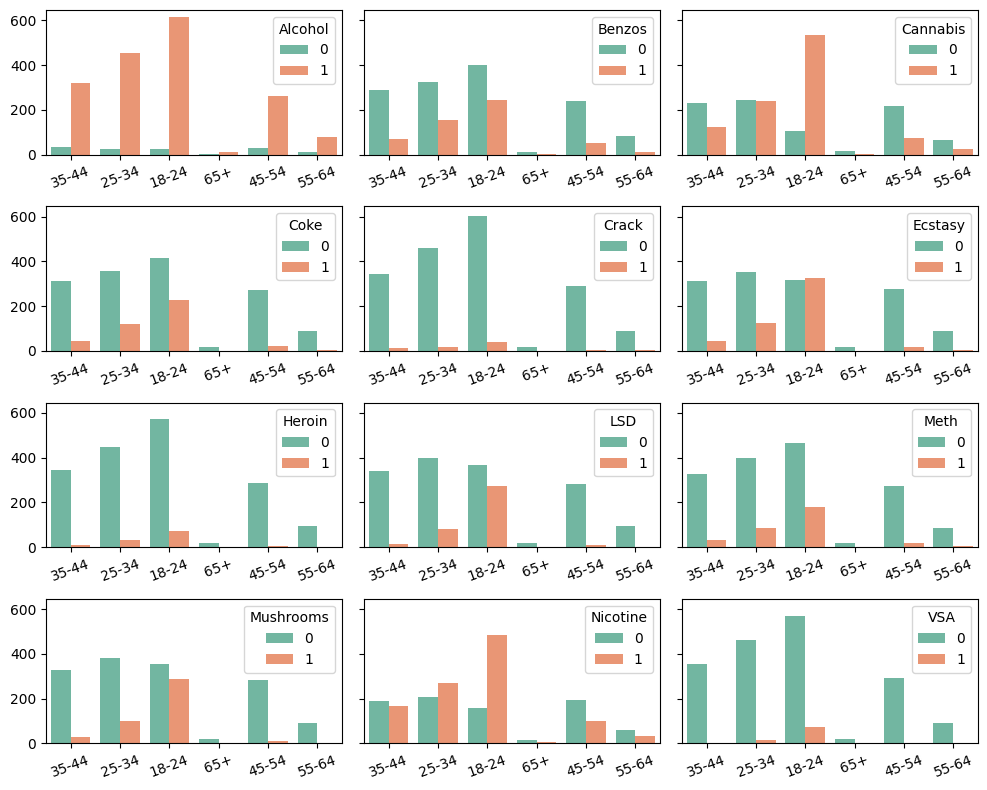

In [14]:
# Distribution of users/non-users per age range for each drug
fig, axes = plt.subplots(4, 3, figsize=(10, 8), sharey=True)

for ax, coluna in zip(axes.flatten(), df_drugs.columns):
    sns.countplot(x='Age', hue=coluna, data=df, ax=ax)
    ax.set_ylabel('')  # Remove y-axis label
    ax.set_xlabel('')  # Remove x-axis label
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

plt.tight_layout()
plt.show()

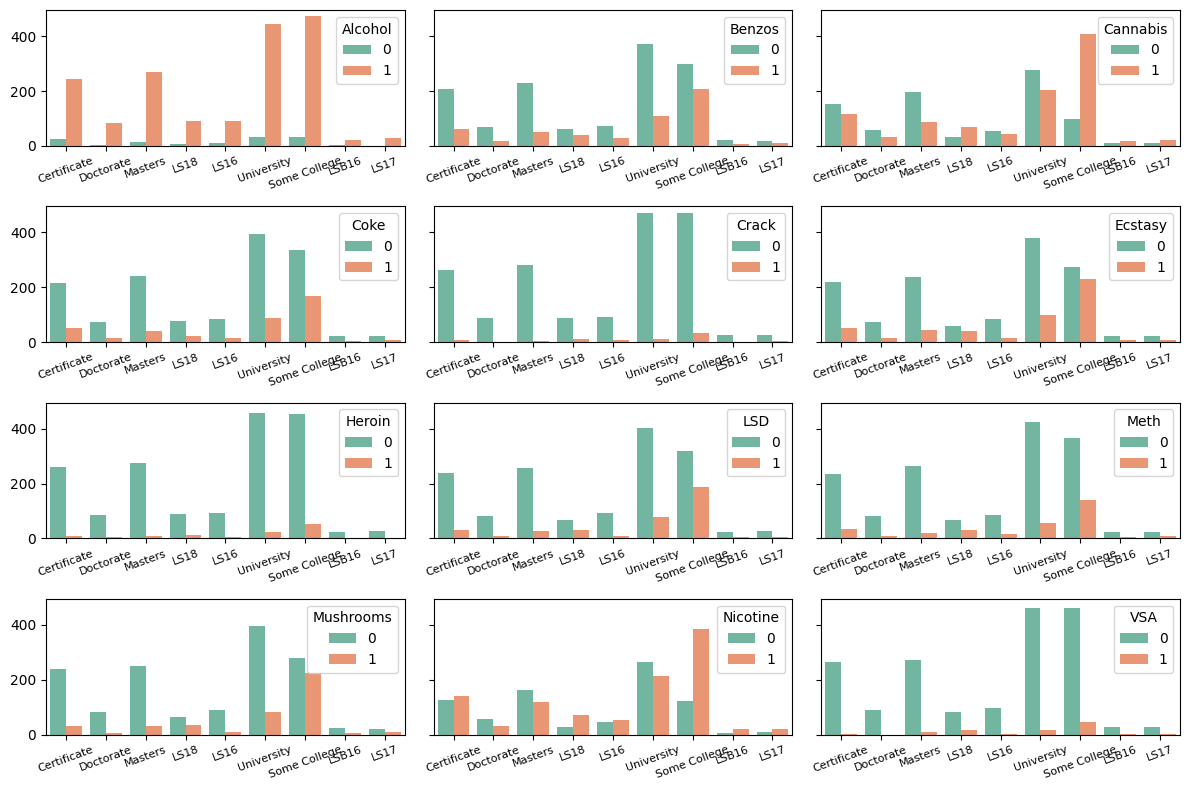

In [15]:
# Distribution of drug use per education level
fig, axes = plt.subplots(4, 3, figsize=(12, 8), sharey=True)

for ax, coluna in zip(axes.flatten(), df_drugs.columns):
    sns.countplot(x='Education', hue=coluna, data=df, ax=ax)
    ax.set_ylabel('')  # Remove y-axis label
    ax.set_xlabel('')  # Remove x-axis label
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, fontsize=8)  # Adjust font size if necessary

plt.tight_layout()
plt.show()

### Graphic Interpretation

Something that needs to be pointed out is that the data comes from a survey, which means we cannot look at total values alone, as a specific group might have been interviewed more than another. For example, at first glance, it is easy to conclude from the graph that university students use more drugs, but is that really true?

In [16]:
# Calculate the percentage of Coke users by education level
coke_sum = df.groupby('Education')['Coke'].sum()
coke_count = df.groupby('Education')['Coke'].count()
edu_df = pd.DataFrame({
    'Coke Users (%)': round((coke_sum / coke_count) * 100, 2),
    'Total': coke_count
}).reset_index()

edu_df

,Education,Coke Users (%),Total
0,Certificate,19.63,270
1,Doctorate,16.85,89
2,LS16,15.15,99
3,LS17,30.00,30
4,LS18,24.00,100
5,LSB16,17.86,28
6,Masters,14.13,283
7,Some College,33.40,506
8,University,18.12,480


Well... It is!! As we can see, the highest concentration of cocaine users in the education sectors of our sample is among individuals with unfinished university degrees, however, it is worth noting that we have an unbalanced database with few samples; therefore, perhaps this analysis may not apply to the entire world. With more data, it would be possible to achieve greater accuracy in this information.

In [17]:
# Calculate the percentage of Coke users by age group
coke_sum_by_age = df.groupby('Age')['Coke'].sum()
coke_count_by_age = df.groupby('Age')['Coke'].count()
age_df = pd.DataFrame({
    'Coke Users (%)': round((coke_sum_by_age / coke_count_by_age) * 100, 2),
    'Total': coke_count_by_age
}).reset_index()

age_df

,Age,Coke Users (%),Total
0,18-24,35.15,643
1,25-34,25.36,481
2,35-44,12.64,356
3,45-54,6.80,294
4,55-64,4.30,93
5,65+,0.00,18


### Personality Tests

#### NEO-FFI-R 

These 5 metrics are results of the NEO-FFI-R personality test from psychology, namely:

**Nscore -> Neuroticism**:  Individuals who score high are more likely to be moody and to experience such feelings as anxiety, worry, fear, anger, frustration, envy, jealousy, guilt, depressed mood, and loneliness.

**EScore -> Extraversion**: It indicates how outgoing and social a person is. A person who scores high enjoy being with people, participating in social gatherings.

**Oscore -> Openness to experience**: It indicates how open-minded a person is. A person with a high level enjoys trying new things. They are imaginative, curious, and open-minded. Individuals who are low in openness to experience would rather not try new things.

**Ascore -> Agreeableness**: A person with a high level of agreeableness is usually warm, friendly, and tactful. They generally have an optimistic view of human nature and get along well with others.

**Cscore -> Conscientiousness**: A person scoring high in conscientiousness usually has a high level of self-discipline. These individuals prefer to follow a plan, rather than act spontaneously. Their methodic planning and perseverance usually makes them highly successful in their chosen occupation. 



A more detailed explanation can be seen in the data card of this dataset.(https://www.kaggle.com/datasets/mexwell/drug-consumption-classification/data)

In [18]:
# To see an overview of relationships between selected features and 'Coke', use the following line:
# This line is commented out to avoid increasing the runtime of the notebook.
# sns.pairplot(df[['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Coke']], hue='Coke')

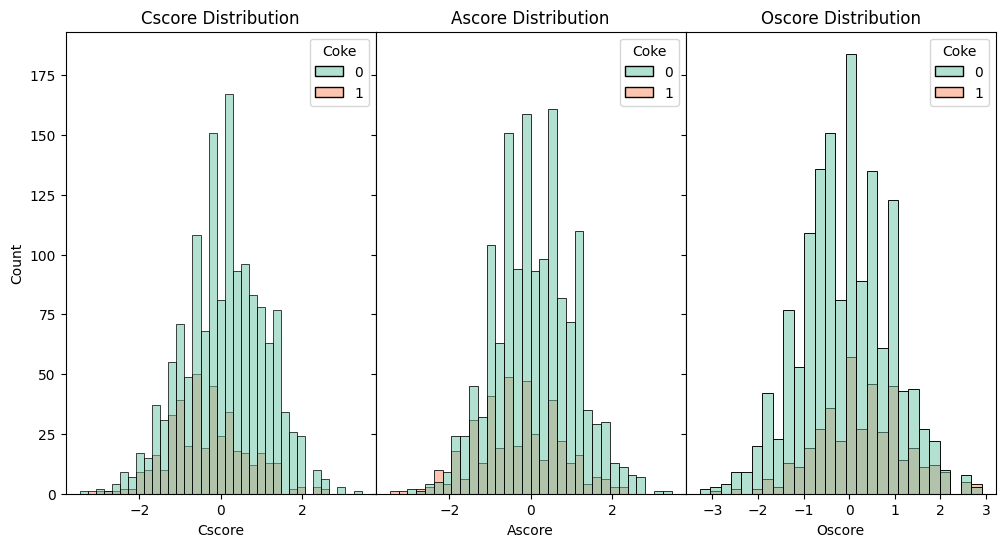

In [19]:
# Histograms of scores relevant to the problem
fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

# Plot histograms for 'Cscore', 'Ascore', and 'Oscore'
sns.histplot(data=df, x='Cscore', hue='Coke', ax=axes[0])
axes[0].set_title('Cscore Distribution')
sns.histplot(data=df, x='Ascore', hue='Coke', ax=axes[1])
axes[1].set_title('Ascore Distribution')
sns.histplot(data=df, x='Oscore', hue='Coke', ax=axes[2])
axes[2].set_title('Oscore Distribution')

plt.subplots_adjust(wspace=.0, hspace=0)  # Adjust spacing between plots
plt.show()

As we can see, there is a slight tail to the left in the first two graphs, which could indicate that people with a **lack of discipline** and **pessimists** tend to use cocaine more frequently. Additionally, open-minded individuals have a slight tendency to use the drug.

#### BIS-11 | ImpSS 

**Impulsive -> Impulsiveness**: Tendency to act on a whim, displaying behavior characterized by little or no forethought, reflection, or consideration of the consequences.

**SS -> Sensation**: Is input about the physical world obtained by our sensory receptors, and perception is the process by which the brain selects, organizes, and interprets these sensations. In other words, senses are the physiological basis of perception.

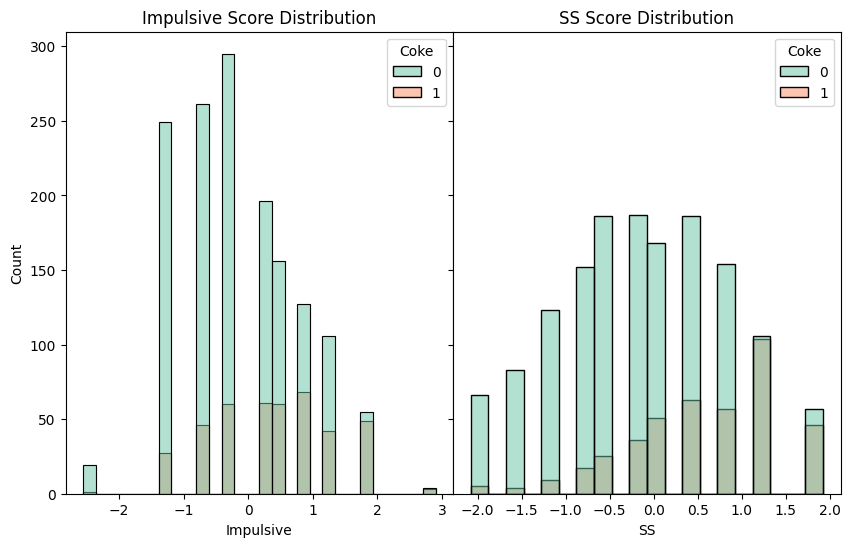

In [20]:
# Histograms of 'Impulsive' and 'SS' with hue based on 'Coke'
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# Plot histogram for 'Impulsive'
sns.histplot(data=df, x='Impulsive', hue='Coke', ax=axes[0])
axes[0].set_title('Impulsive Score Distribution')

# Plot histogram for 'SS'
sns.histplot(data=df, x='SS', hue='Coke', ax=axes[1])
axes[1].set_title('SS Score Distribution')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=.0, hspace=0)
plt.show()

These metrics are different from the others because they have a smaller number of possible values. However, it is notable that impulsive people and those who are perceptive of the world around them use the drug more than those who do not.

**With this, we conclude the visualizations of the variables in our problem. We have learned that, in our sample, university students aged between 18 and 24 have a higher likelihood of substance use. Additionally, pessimistic, impulsive, sensitive individuals, and those interested in experimenting new things show a greater tendency toward drug use.Those variables will be essential for our model.**

# Classification

In [21]:
# Separating the target variables from the independent variables
# DataFrame with independent variables
df_v = df[['Age', 'Education', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']]

# DataFrame with target variables (drug use)
df_d = df[['Alcohol', 'Benzos', 'Cannabis', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'VSA']]

## Atributos

In [22]:
# Check for correlations greater than 0.9 among numerical variables
correlation_matrix = df_v.select_dtypes('number').corr()
high_correlation = correlation_matrix[correlation_matrix > 0.9]

# Display the high correlations
print(high_correlation)

           Nscore  Escore  Oscore  Ascore  Cscore  Impulsive   SS
Nscore        1.0     NaN     NaN     NaN     NaN        NaN  NaN
Escore        NaN     1.0     NaN     NaN     NaN        NaN  NaN
Oscore        NaN     NaN     1.0     NaN     NaN        NaN  NaN
Ascore        NaN     NaN     NaN     1.0     NaN        NaN  NaN
Cscore        NaN     NaN     NaN     NaN     1.0        NaN  NaN
Impulsive     NaN     NaN     NaN     NaN     NaN        1.0  NaN
SS            NaN     NaN     NaN     NaN     NaN        NaN  1.0


## Hot Encode

It helps in preserving the nature of categorical variables, improves model performance, and ensures compatibility with various algorithms while handling unknown categories effectively and avoiding issues like multicollinearity.

In [23]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
# handle_unknown='ignore' ensures that unknown categories are ignored
# sparse_output=False returns a dense array (DataFrame)
# drop='first' removes the first category to avoid multicollinearity
hot_encode = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

# Fit the encoder on the categorical features
categorical_features = df_v.select_dtypes(exclude='number')
hot_encode.fit(categorical_features)

# Transform the categorical features and create a DataFrame
df_v_hot = pd.DataFrame(hot_encode.transform(categorical_features), columns=hot_encode.get_feature_names_out())

# Concatenate the encoded features with the numerical features
df_v = df_v_hot.join(df_v.select_dtypes('number'))
df_v.head()

,Age_25-34,Age_35-44,Age_45-54,Age_55-64,Age_65+,Education_Doctorate,Education_LS16,Education_LS17,Education_LS18,Education_LSB16,Education_Masters,Education_Some College,Education_University,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575


## Normalization

It helps in improving model convergence, handling features with different scales, enhancing model performance, ensuring stable weight updates, preventing numerical instability, and improving interpretability. By scaling features to a common range, normalization ensures that all features contribute equally to the learning process, leading to more robust and reliable models.

In [24]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the DataFrame
scaler.fit(df_v)

# Transform the data
df_v_scaled = scaler.transform(df_v)

# Create a DataFrame with the scaled data
df_v_scaled = pd.DataFrame(df_v_scaled, columns=df_v.columns)

df_v = df_v_scaled
df_v.head()

,Age_25-34,Age_35-44,Age_45-54,Age_55-64,Age_65+,Education_Doctorate,Education_LS16,Education_LS17,Education_LS18,Education_LSB16,Education_Masters,Education_Some College,Education_University,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS
0,-0.585314,2.072425,-0.429871,-0.22781,-0.098189,-0.222609,-0.235438,-0.127171,-0.236691,-0.122793,-0.420302,-0.60575,-0.584497,0.313500,-0.576912,-0.585137,-0.919341,-0.006281,-0.235108,-1.222226
1,1.708484,-0.482527,-0.429871,-0.22781,-0.098189,4.492190,-0.235438,-0.127171,-0.236691,-0.122793,-0.420302,-0.60575,-0.584497,-0.679764,1.944499,1.441683,0.763361,-0.142775,-0.752976,-0.220519
2,-0.585314,2.072425,-0.429871,-0.22781,-0.098189,-0.222609,-0.235438,-0.127171,-0.236691,-0.122793,-0.420302,-0.60575,-0.584497,-0.468308,0.807667,-0.850217,-1.625245,-1.016902,-1.453650,0.420129
3,-0.585314,-0.482527,-0.429871,-0.22781,-0.098189,-0.222609,-0.235438,-0.127171,-0.236691,-0.122793,2.379239,-0.60575,-0.584497,-0.149189,-0.808263,-0.018822,0.592338,0.586885,-1.453650,-1.222226
4,-0.585314,2.072425,-0.429871,-0.22781,-0.098189,4.492190,-0.235438,-0.127171,-0.236691,-0.122793,-0.420302,-0.60575,-0.584497,0.736994,-1.637850,-0.453034,-0.302329,1.310098,-0.235108,-0.220519


## Modeling

During this stage, I tested different models, such as Decision Trees, Logistic Regressions, Gaussian Naive Bayes, and MLPs. It appeared that Random Forests were the most effective, which is why this will be the model used. A good characteristic of Random Forest is the *balanced* parameter, which allows changing the class weights, making it suitable for dealing with imbalanced datasets. It's worth noting that, except for Nicotine and Cannabis, all our other targets are imbalanced.

In [25]:
# Define the model for imbalanced classes
base_estimator_un = RandomForestClassifier(class_weight='balanced', random_state=123)

# Define the model for balanced classes
base_estimator = RandomForestClassifier(random_state=123)

# Define the hyperparameters to be tested
param_grid = {
    'n_estimators': [10, 50, 100, 1000],
    'criterion': ['gini', 'entropy', 'log_loss']
}

In [26]:
# Define the Grid Search with Cross-Validation for balanced classes
clf = GridSearchCV(
    estimator=base_estimator,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1  # Use all available CPU cores
)

# Define the Grid Search with Cross-Validation for imbalanced classes
clf_un = GridSearchCV(
    estimator=base_estimator_un,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1  # Use all available CPU cores
)

In [27]:
target_columns = df_d.columns
metrics = {col: {} for col in target_columns}

metrics

{'Alcohol': {},
 'Benzos': {},
 'Cannabis': {},
 'Coke': {},
 'Crack': {},
 'Ecstasy': {},
 'Heroin': {},
 'LSD': {},
 'Meth': {},
 'Mushrooms': {},
 'Nicotine': {},
 'VSA': {}}

### Training

In [28]:
# Define the features and target variables
X = df_v
target_columns = ['Nicotine', 'Cannabis']

Processing Targets:   0%|          | 0/2 [00:00<?, ?it/s]

Target: Nicotine, Model: RandomForestClassifier(random_state=123)


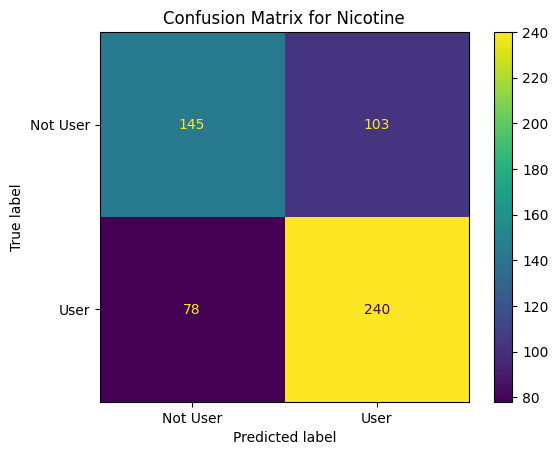

Processing Targets:  50%|█████     | 1/2 [00:28<00:28, 28.21s/it]

Target: Cannabis, Model: RandomForestClassifier(n_estimators=1000, random_state=123)


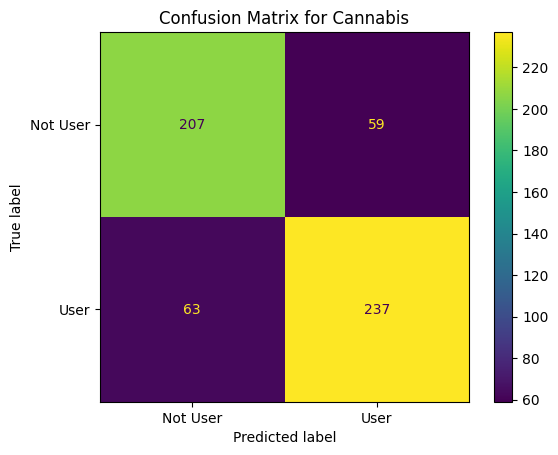

Processing Targets: 100%|██████████| 2/2 [00:55<00:00, 27.63s/it]


In [29]:
from tqdm import tqdm

# Iterate over the target columns to fit and evaluate the model
for col in tqdm(target_columns, desc="Processing Targets"):
    y = df_d[col]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=123
    )
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Store results in the metrics dictionary
    metrics[col]['model'] = clf.best_estimator_
    metrics[col]['report'] = classification_report(y_test, y_pred, output_dict=True)
    metrics[col]['confusion_matrix'] = ConfusionMatrixDisplay(
        confusion_matrix(y_test, y_pred), display_labels=['Not User', 'User']
    )
    
    print(f'Target: {col}, Model: {clf.best_estimator_}')
    metrics[col]['confusion_matrix'].plot()
    plt.title(f'Confusion Matrix for {col}')
    plt.show()

In [30]:
# Define the features and target variables
target_columns = df_d.drop(columns=['Cannabis', 'Nicotine']).columns

Processing Targets:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Target: Alcohol, Model: RandomForestClassifier(class_weight='balanced', n_estimators=50,
                       random_state=123)


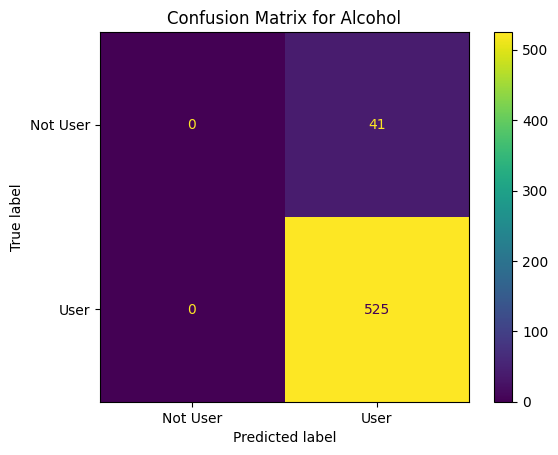

Processing Targets:  10%|█         | 1/10 [00:21<03:15, 21.70s/it]

Target: Benzos, Model: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=10, random_state=123)


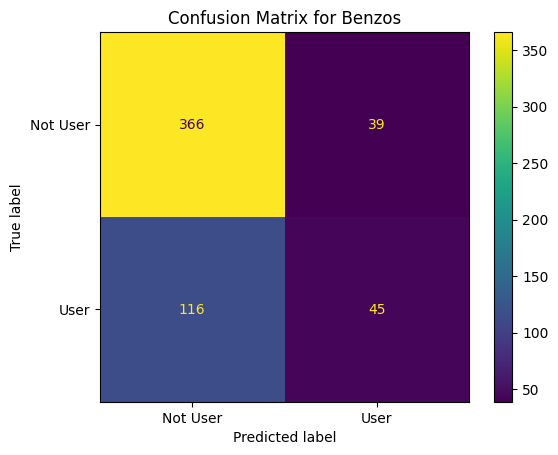

Processing Targets:  20%|██        | 2/10 [00:45<03:04, 23.07s/it]

Target: Coke, Model: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=10, random_state=123)


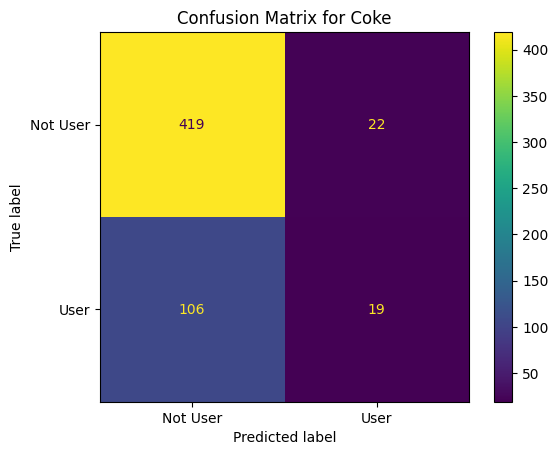

Processing Targets:  30%|███       | 3/10 [01:09<02:42, 23.21s/it]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Target: Crack, Model: RandomForestClassifier(class_weight='balanced', n_estimators=10,
                       random_state=123)


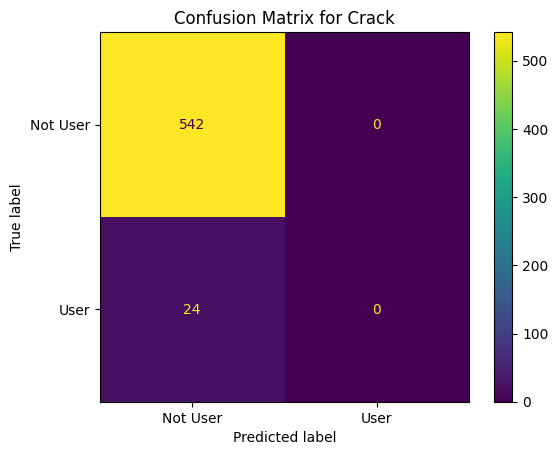

Processing Targets:  40%|████      | 4/10 [01:28<02:11, 21.85s/it]

Target: Ecstasy, Model: RandomForestClassifier(class_weight='balanced', n_estimators=1000,
                       random_state=123)


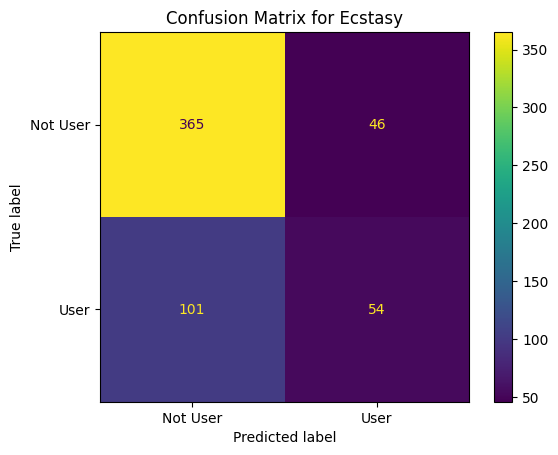

Processing Targets:  50%|█████     | 5/10 [01:56<01:59, 23.87s/it]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Target: Heroin, Model: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=50, random_state=123)


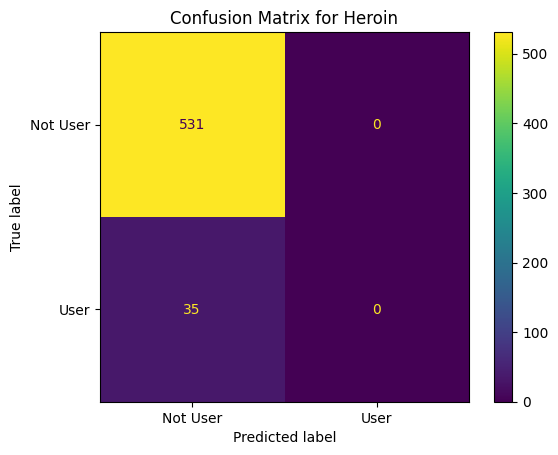

Processing Targets:  60%|██████    | 6/10 [02:17<01:31, 22.91s/it]

Target: LSD, Model: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=1000, random_state=123)


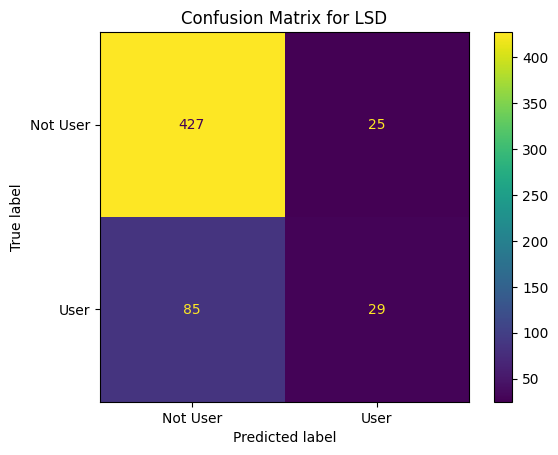

Processing Targets:  70%|███████   | 7/10 [02:44<01:12, 24.22s/it]

Target: Meth, Model: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=10, random_state=123)


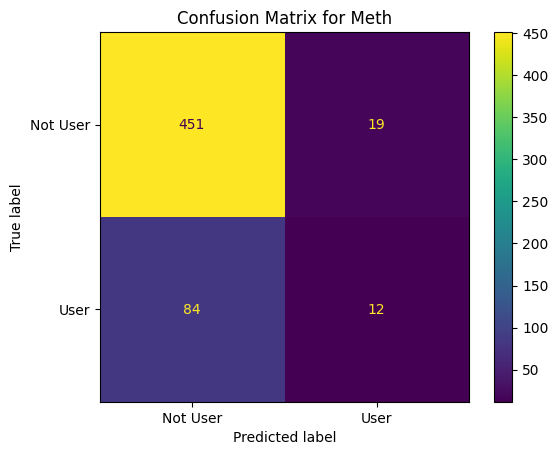

Processing Targets:  80%|████████  | 8/10 [03:06<00:47, 23.64s/it]

Target: Mushrooms, Model: RandomForestClassifier(class_weight='balanced', n_estimators=1000,
                       random_state=123)


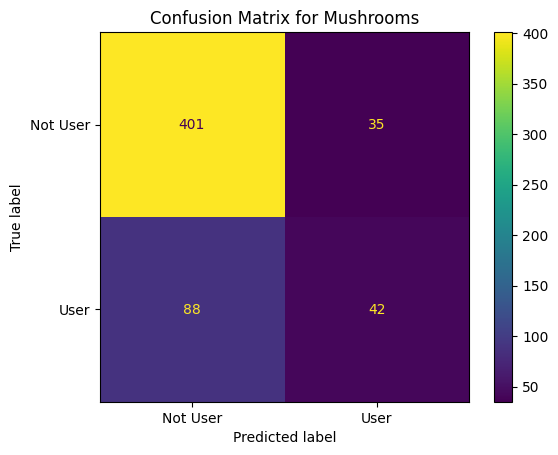

Processing Targets:  90%|█████████ | 9/10 [03:33<00:24, 24.52s/it]

Target: VSA, Model: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=10, random_state=123)


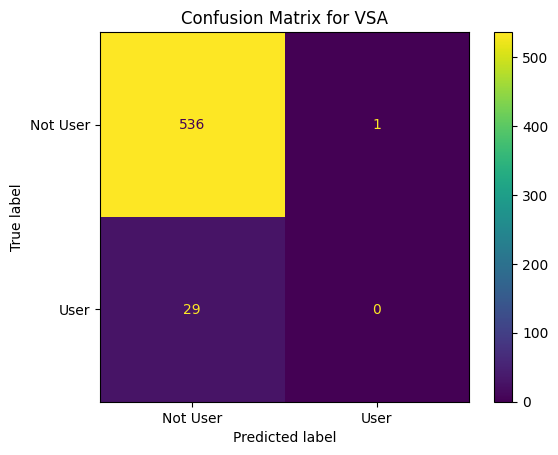

Processing Targets: 100%|██████████| 10/10 [03:54<00:00, 23.40s/it]


In [31]:
# Iterate over the target columns to fit and evaluate the model
for col in tqdm(target_columns, desc="Processing Targets"):
    y = df_d[col]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=123
    )
    
    clf_un.fit(X_train, y_train)
    y_pred = clf_un.predict(X_test)
    
    # Store results in the metrics dictionary
    if col not in metrics:
        metrics[col] = {}  # Ensure that the column exists in the metrics dictionary
    metrics[col]['model'] = clf_un.best_estimator_
    metrics[col]['report'] = classification_report(y_test, y_pred, output_dict=True)
    metrics[col]['confusion_matrix'] = ConfusionMatrixDisplay(
        confusion_matrix(y_test, y_pred), display_labels=['Not User', 'User']
    )
    
    # Print and display results
    print(f'Target: {col}, Model: {clf_un.best_estimator_}')
    metrics[col]['confusion_matrix'].plot()
    plt.title(f'Confusion Matrix for {col}')
    plt.show()

## Eval

In [32]:
# Transforming the metrics into a DataFrame
results = pd.DataFrame(target_columns, columns=['Drugs'])
results['accuracy'] = results['Drugs'].map(lambda x: metrics[x]['report']['accuracy'])

# Extract precision, recall, and f1-score from the metrics and add to the DataFrame
for metric in ['precision', 'recall', 'f1-score']:
    results[metric] = results['Drugs'].map(
        lambda x: round(metrics[x]['report']['0'][metric], 2)
    )

results

,Drugs,accuracy,precision,recall,f1-score
0,Alcohol,0.927562,0.00,0.00,0.00
1,Benzos,0.726148,0.76,0.90,0.83
2,Coke,0.773852,0.80,0.95,0.87
3,Crack,0.957597,0.96,1.00,0.98
4,Ecstasy,0.740283,0.78,0.89,0.83
5,Heroin,0.938163,0.94,1.00,0.97
6,LSD,0.805654,0.83,0.94,0.89
7,Meth,0.818021,0.84,0.96,0.90
8,Mushrooms,0.782686,0.82,0.92,0.87
9,VSA,0.946996,0.95,1.00,0.97


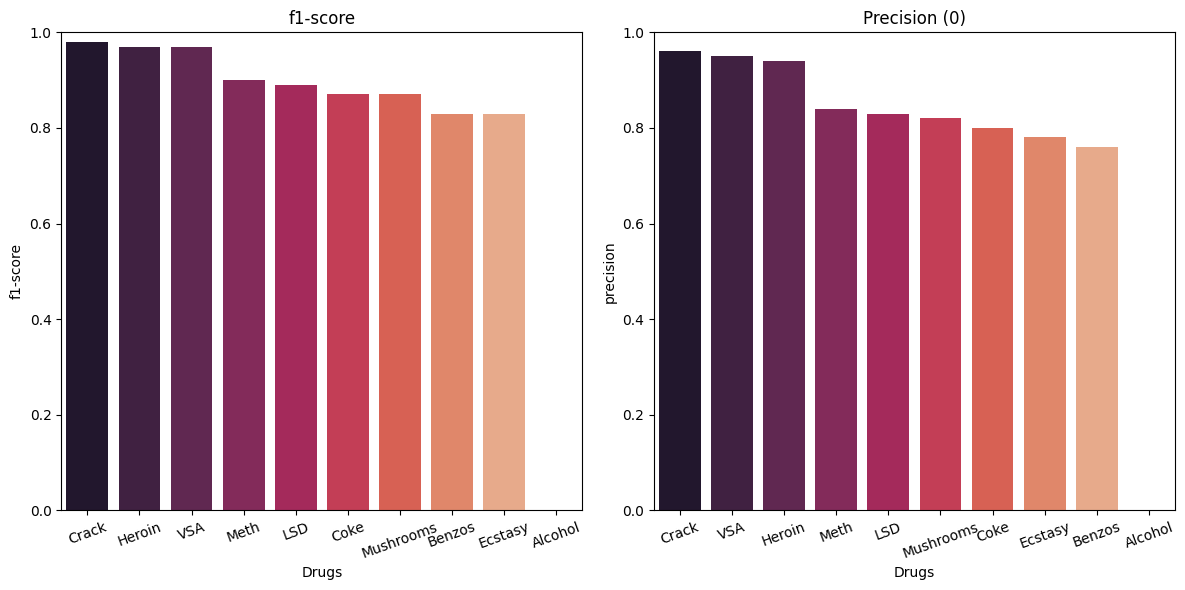

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot f1-score
sns.barplot(
    data=results.sort_values(by='f1-score', ascending=False),
    x='Drugs', y='f1-score', palette='rocket', ax=ax1
)
ax1.set_title('f1-score')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='x', rotation=20, labelsize=10)

# Plot precision
sns.barplot(
    data=results.sort_values(by='precision', ascending=False),
    x='Drugs', y='precision', palette='rocket', ax=ax2
)
ax2.set_title('Precision (0)')
ax2.set_ylim(0, 1)
ax2.tick_params(axis='x', rotation=20, labelsize=10)


plt.tight_layout()
#plt.savefig('f1score_precision.png', dpi=300)  # Uncomment to save the figure
plt.show()

# Conclusion

## Results

**The model achieved above 70% F1-score for all drugs except Nicotine and Alcohol, maintaining an accuracy above 50% for all drugs except Alcohol.**

**Considerations**:
*     We have imbalanced classes, where most of the respondents were not users of harder drugs, so it makes sense to have high scores for them. For example, in the dataframe, you can see that 96% of users did not use crack, so a simple deduction that all people are *non-users* of crack would give us an accuracy of 96%, which is not necessarily a positive thing. It would be like boasting about correctly identifying 96% of the teams that a group of people supports inside a stadium without mixed fans. The model has high precision because the metric does not consider false negatives, i.e., it does not calculate errors where the guess was a user, and the person in question was not;


*     However, in a problem like this, where an incentive to avoid drug use could be implemented, false positives are much more harmful, as they would fail to help someone who needs assistance. False negatives would only help someone who might not necessarily need it. Therefore, looking at the precision of the target 0 is a viable option in this case;


*     With more data, we could have a more robust model, with more test sets and more diversification, which would ensure its applicability. However, the study proved satisfactory for what it proposes, showing that this type of analysis has potential.

## What is the F1-score and why do we use it as a metric for model evaluation?

The F1 score is calculated as the harmonic mean of precision and recall. It provides a balance between precision and recall:

 
A high F1 score indicates both high precision and high recall, which implies that the model is performing well in terms of both identifying relevant instances and minimizing false positives. It is particularly useful in situations where you want to find an optimal balance between precision and recall, such as in binary classification tasks where the classes are imbalanced.